# 03 Networks exploration

This notebook shows how networks were built and visualised based on the output from the topic model.

In [1]:
library(tidyverse)
library(tidytext)
library(topicmodels)

library(igraph)
library(sna)
library(ggraph)

library(wesanderson)
library(patchwork)
theme_set(theme_minimal())

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.1     ✔ purrr   1.0.1
✔ tibble  3.1.8     ✔ dplyr   1.1.0
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.4     ✔ forcats 1.0.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Dołączanie pakietu: ‘igraph’


Następujące obiekty zostały zakryte z ‘package:dplyr’:

    as_data_frame, groups, union


Następujące obiekty zostały zakryte z ‘package:purrr’:

    compose, simplify


Następujący obiekt został zakryty z ‘package:tidyr’:

    crossing


Następujący obiekt został zakryty z ‘package:tibble’:

    as_data_frame


Następujące obiekty zostały zakryte z ‘package:stats’:

    decompose, spectrum


Następujący obiekt został zakryty z ‘package:base’:

    union


Ładowanie wymaganego pakietu: statnet.common


Dołączanie pakietu: ‘statnet.common’


Następujące obiekty zostały zakryte z

In [2]:
# load model output
load("../data/lda75_output.Rda")

# load code for edges calculation
source("03_fn_calculate_edges.R")

# function to extract topic lables:
get_topic_labels = function(x, n_labels = 10) {
  
  #takes beta-matrix as an input
  top_terms = x %>%
    group_by(topic) %>%
    top_n(20, beta) %>%
    ungroup() %>%
    arrange(topic, -beta)
  
  topic_labels = top_terms %>%
    group_by(topic) %>%
    top_n(n_labels, beta) %>%
    summarise(label=paste(term, collapse=" ")) %>%
    mutate(label = paste(topic, label, sep="_"))
  
  return(topic_labels)
}

# prepare gamma data
gamma <- gamma %>% 
    # add index for create_edges function
    mutate(index = paste0(corpus, "_", id)) %>% 
    # fix typo
    rename(author = first_line)

glimpse(gamma)

Rows: 1,076,700
Columns: 8
$ corpus  <chr> "N", "N", "N", "N", "N", "N", "N", "N", "N", "N", "N", "N", "N…
$ id      <chr> "1-1", "1-2", "1-3", "10-1", "10-2", "100-1", "100-2", "100-3"…
$ year    <chr> "1785", "1785", "1785", "1803", "1803", "1810", "1810", "1810"…
$ author  <chr> "ССБобров", "ССБобров", "ССБобров", "ССБобров", "ССБобров", "А…
$ formula <chr> "iamb_4", "iamb_4", "iamb_4", "iamb_4", "iamb_4", "iamb_6", "i…
$ topic   <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,…
$ gamma   <dbl> 0.019108280, 0.006211180, 0.006451613, 0.006211180, 0.00763358…
$ index   <chr> "N_1-1", "N_1-2", "N_1-3", "N_10-1", "N_10-2", "N_100-1", "N_1…


Extract topic labels

In [3]:
topic_labels <- get_topic_labels(beta, n_labels = 5)
head(topic_labels)

topic label                                 
1 1     1_старик девица красный молодой старый
2 2     2_брат два жена муж другой            
3 3     3_искать исчезать везде дух след      
4 4     4_дева прекрасный краса чистый молодой
5 5     5_бог давать сила боже господь        
6 6     6_слава великий герой отечество россия

Create edges: detect highly probable topics appeared in the same poems

In [4]:
edges_raw <- compute_edges(gamma,
                           gamma_thresh = 0.05,
                           time_slice = 5)

head(edges_raw)

edges_raw %>% 
  filter(corpus == "P") %>% 
  head

corpus id      year author     formula                   topic gamma     
1 N      10256   1814 АННахимов  iamb_free                 1     0.06569343
2 N      10296-1 1848 НАНекрасов anapaest_регулярная:3+2#3 1     0.13548387
3 N      10296-1 1848 НАНекрасов anapaest_регулярная:3+2#3 1     0.13548387
4 N      10296-1 1848 НАНекрасов anapaest_регулярная:3+2#3 1     0.13548387
5 N      10296-1 1848 НАНекрасов anapaest_регулярная:3+2#3 1     0.13548387
6 N      10302   1850 НАНекрасов iamb_6                    1     0.05660377
  index     from to slice edge_id source                                
1 N_10256   1    46 1810  1 46    1_старик девица красный молодой старый
2 N_10296-1 1    15 1845  1 15    1_старик девица красный молодой старый
3 N_10296-1 1    57 1845  1 57    1_старик девица красный молодой старый
4 N_10296-1 1    58 1845  1 58    1_старик девица красный молодой старый
5 N_10296-1 1    59 1845  1 59    1_старик девица красный молодой старый
6 N_10302   1     3 1850  1 3     1_старик девица красный молодой старый
  target                                          
1 46_стих писать читать перо поэт                 
2 15_пить вино чаша пир гость                     
3 57_другой хотеть иной становиться говорить      
4 58_день ночь тень час утро                      
5 59_сказать становиться хорошо говорить приходить
6 3_искать исчезать везде дух след

corpus id     year author     formula   topic gamma      index    from to
1 P      1007-1 1838 РодзянкоАГ iamb_4    1     0.06285714 P_1007-1 1    13
2 P      1007-1 1838 РодзянкоАГ iamb_4    1     0.06285714 P_1007-1 1    39
3 P      1007-1 1838 РодзянкоАГ iamb_4    1     0.06285714 P_1007-1 1    69
4 P      1007-1 1838 РодзянкоАГ iamb_4    1     0.06285714 P_1007-1 1    73
5 P      1029   1839 ГротЯК     trochee_4 1     0.07692308 P_1029   1    32
6 P      1030-2 1839 ГротЯК     trochee_5 1     0.12077295 P_1030-2 1    29
  slice edge_id source                                
1 1835  1 13    1_старик девица красный молодой старый
2 1835  1 39    1_старик девица красный молодой старый
3 1835  1 69    1_старик девица красный молодой старый
4 1835  1 73    1_старик девица красный молодой старый
5 1835  1 32    1_старик девица красный молодой старый
6 1835  1 29    1_старик девица красный молодой старый
  target                               
1 13_меч бой враг герой поле           
2 39_ум труд свет наука глупец         
3 69_царь народ русский царство князь  
4 73_конь дорога поле бежать лететь    
5 32_весна поле снег ветер зима        
6 29_слово сказать говорить знать никто

Create links for network

In [5]:
# select top meters
meter_counts <- gamma %>% 
  mutate(year_span = floor(as.numeric(year)/5)*5) %>% 
  rename("meter" = "formula") %>% 
  filter(!str_detect(meter, "other")) %>% 
  group_by(year_span, meter) %>% 
  count(sort = T) %>% 
  ungroup() %>% 
  filter(n > 10 & year_span != 1850)

head(meter_counts)

year_span meter     n    
1 1825      iamb_4    54975
2 1835      iamb_4    44775
3 1830      iamb_4    37050
4 1820      iamb_4    36450
5 1835      iamb_free 30525
6 1835      trochee_4 25425

In [6]:
top_meters <- meter_counts %>% 
  group_by(meter) %>%
  summarise(total = sum(n)) %>% 
  arrange(desc(total))

head(top_meters, 15)
top_meters$meter[1:8]

meter                  total 
1  iamb_4                 316425
2  iamb_free              183900
3  trochee_4              123300
4  iamb_6                 117150
5  iamb_5                  62100
6  iamb_3                  25725
7  amphibrach_4            15150
8  iamb_регулярная:4+3     10425
9  amphibrach_3             6750
10 trochee_free             6000
11 NA                       5925
12 trochee_3                5625
13 amphibrach_free          5175
14 amphibrach_2             4800
15 trochee_регулярная:4+3   4800

[1] "iamb_4"              "iamb_free"           "trochee_4"          
[4] "iamb_6"              "iamb_5"              "iamb_3"             
[7] "amphibrach_4"        "iamb_регулярная:4+3"

## RNC networks

In [8]:
links <- edges_raw %>% 
  mutate(meter = formula) %>%
  # filter out only 8 most interesting meters
  filter(meter %in% top_meters$meter[1:8]) %>% 
  # group and count edges
  group_by(slice, meter, corpus) %>% 
  count(slice, meter, edge_id, source, target, sort = T) %>% 
  # filter non-frequent edges
  filter(n > 2) %>% 
  ungroup() 

# quick check
links %>% 
  filter(corpus == "N") %>% 
  head

slice meter     corpus edge_id source                                    
1 1780  iamb_free N      41 57   41_лев волк зверь собака большой          
2 1840  trochee_4 N      36 51   36_знать говорить точно два очень         
3 1780  iamb_free N      57 59   57_другой хотеть иной становиться говорить
4 1780  iamb_free N      20 57   20_богатый жить дом служить бедный        
5 1810  iamb_free N      41 59   41_лев волк зверь собака большой          
6 1825  iamb_4    N      19 42   19_муза певец слава дар поэт              
  target                                           n 
1 57_другой хотеть иной становиться говорить       23
2 51_сидеть окно дверь дом стоять                  20
3 59_сказать становиться хорошо говорить приходить 19
4 57_другой хотеть иной становиться говорить       16
5 59_сказать становиться хорошо говорить приходить 16
6 42_душа мечта поэт живой восторг                 16

Create edge and node lists

In [9]:
edgelist <- links %>% 
  select(source, target, n, meter, slice, corpus) %>% 
  mutate(width = n/10) %>% 
  filter(slice != 1850)

nodelist <- tibble(source = unique(c(links$target, links$source))) %>% 
  mutate(idn = as.numeric(str_replace(source, "^([0-9].*?)_.*", "\\1"))) 

 head(edgelist)
 head(nodelist) 
 nrow(nodelist)

source                                    
1 41_лев волк зверь собака большой          
2 36_знать говорить точно два очень         
3 57_другой хотеть иной становиться говорить
4 20_богатый жить дом служить бедный        
5 41_лев волк зверь собака большой          
6 19_муза певец слава дар поэт              
  target                                           n  meter     slice corpus
1 57_другой хотеть иной становиться говорить       23 iamb_free 1780  N     
2 51_сидеть окно дверь дом стоять                  20 trochee_4 1840  N     
3 59_сказать становиться хорошо говорить приходить 19 iamb_free 1780  N     
4 57_другой хотеть иной становиться говорить       16 iamb_free 1780  N     
5 59_сказать становиться хорошо говорить приходить 16 iamb_free 1810  N     
6 42_душа мечта поэт живой восторг                 16 iamb_4    1825  N     
  width
1 2.3  
2 2.0  
3 1.9  
4 1.6  
5 1.6  
6 1.6

source                                           idn
1 57_другой хотеть иной становиться говорить       57 
2 51_сидеть окно дверь дом стоять                  51 
3 59_сказать становиться хорошо говорить приходить 59 
4 42_душа мечта поэт живой восторг                 42 
5 72_гора лес скала дикий стоять                   72 
6 62_знать хотеть ничто сказать бояться            62

[1] 75

### Create network

In [10]:
net <- graph_from_data_frame(d = edgelist, vertices = nodelist, directed = F)
net

IGRAPH 94abf0b UN-- 75 4181 -- 
+ attr: name (v/c), idn (v/n), n (e/n), meter (e/c), slice (e/n),
| corpus (e/c), width (e/n)
+ edges from 94abf0b (vertex names):
[1] 57_другой хотеть иной становиться говорить      --41_лев волк зверь собака большой                
[2] 51_сидеть окно дверь дом стоять                 --36_знать говорить точно два очень               
[3] 57_другой хотеть иной становиться говорить      --59_сказать становиться хорошо говорить приходить
[4] 57_другой хотеть иной становиться говорить      --20_богатый жить дом служить бедный              
[5] 59_сказать становиться хорошо говорить приходить--41_лев волк зверь собака большой                
+ ... omitted several edges

#### Betweenness

In [11]:
# extract betweenness stats
betw = igraph::betweenness(net)
head(betw)

# named vector to tibble
# str(betw)

betw_tib <- as_tibble(as.list(betw)) %>% 
  mutate(x = "x") %>% 
  pivot_longer(!x, names_to = "source", values_to = "betw") %>% 
  select(-x)
head(betw_tib)

# attach betweenness values to nodelist
nodelist <- inner_join(nodelist, betw_tib, by = "source")

57_другой хотеть иной становиться говорить 
                                        34.81001 
                 51_сидеть окно дверь дом стоять 
                                        14.59164 
59_сказать становиться хорошо говорить приходить 
                                        25.93947 
                42_душа мечта поэт живой восторг 
                                        54.97214 
                  72_гора лес скала дикий стоять 
                                        22.85270 
           62_знать хотеть ничто сказать бояться 
                                        14.01633

source                                           betw    
1 57_другой хотеть иной становиться говорить       34.81001
2 51_сидеть окно дверь дом стоять                  14.59164
3 59_сказать становиться хорошо говорить приходить 25.93947
4 42_душа мечта поэт живой восторг                 54.97214
5 72_гора лес скала дикий стоять                   22.85270
6 62_знать хотеть ничто сказать бояться            14.01633

#### degree

In [12]:
# extract degree values
deg <- igraph::degree(net, mode="all")
head(deg)

degree_tib <- as_tibble(as.list(deg)) %>% 
  mutate(x = "x") %>% 
  pivot_longer(!x, names_to = "source", values_to = "degree") %>% 
  select(-x)

# attach degree to nodelist
nodelist <- inner_join(nodelist, degree_tib, by = "source")

head(nodelist)

57_другой хотеть иной становиться говорить 
                                             151 
                 51_сидеть окно дверь дом стоять 
                                              90 
59_сказать становиться хорошо говорить приходить 
                                             134 
                42_душа мечта поэт живой восторг 
                                             219 
                  72_гора лес скала дикий стоять 
                                             137 
           62_знать хотеть ничто сказать бояться 
                                             110

source                                           idn betw     degree
1 57_другой хотеть иной становиться говорить       57  34.81001 151   
2 51_сидеть окно дверь дом стоять                  51  14.59164  90   
3 59_сказать становиться хорошо говорить приходить 59  25.93947 134   
4 42_душа мечта поэт живой восторг                 42  54.97214 219   
5 72_гора лес скала дикий стоять                   72  22.85270 137   
6 62_знать хотеть ничто сказать бояться            62  14.01633 110

In [13]:
head(edgelist)

source                                    
1 41_лев волк зверь собака большой          
2 36_знать говорить точно два очень         
3 57_другой хотеть иной становиться говорить
4 20_богатый жить дом служить бедный        
5 41_лев волк зверь собака большой          
6 19_муза певец слава дар поэт              
  target                                           n  meter     slice corpus
1 57_другой хотеть иной становиться говорить       23 iamb_free 1780  N     
2 51_сидеть окно дверь дом стоять                  20 trochee_4 1840  N     
3 59_сказать становиться хорошо говорить приходить 19 iamb_free 1780  N     
4 57_другой хотеть иной становиться говорить       16 iamb_free 1780  N     
5 59_сказать становиться хорошо говорить приходить 16 iamb_free 1810  N     
6 42_душа мечта поэт живой восторг                 16 iamb_4    1825  N     
  width
1 2.3  
2 2.0  
3 1.9  
4 1.6  
5 1.6  
6 1.6

#### upd net

In [14]:
net <- graph_from_data_frame(d=edgelist, vertices=nodelist, directed=F)

#### build viz

In [15]:
# function for network visualisation

# taken as input net, meter as a string & colour palette value
# corpus is "N" for RNC, "P" for periodicals

network <- function(network, meter_value, corpus_v, palette_v) {
  ggraph(network, layout = "stress") +
    geom_edge_fan(aes(color=meter,
                      filter = meter %in% c(meter_value) & corpus %in% c(corpus_v), 
                      width = n, 
                      alpha = 0.4)) +
    geom_node_point(aes(alpha = degree)) +
    geom_node_text(aes(label=idn), 
                   hjust=0.1, 
                   vjust=-0.4, 
                   size=3, 
                   color="grey50") +
    theme_void() + 
    theme(strip.text = element_text(size = 12)) +
    facet_wrap(~slice, 
               scales="free_x", 
               drop=T,
               ncol = 5) + 
    scale_edge_color_manual(values = palette_v)
}

List of meter values

In [16]:
unique(edgelist$meter)

[1] "iamb_free"           "trochee_4"           "iamb_4"             
[4] "iamb_6"              "iamb_5"              "iamb_3"             
[7] "amphibrach_4"        "iamb_регулярная:4+3"

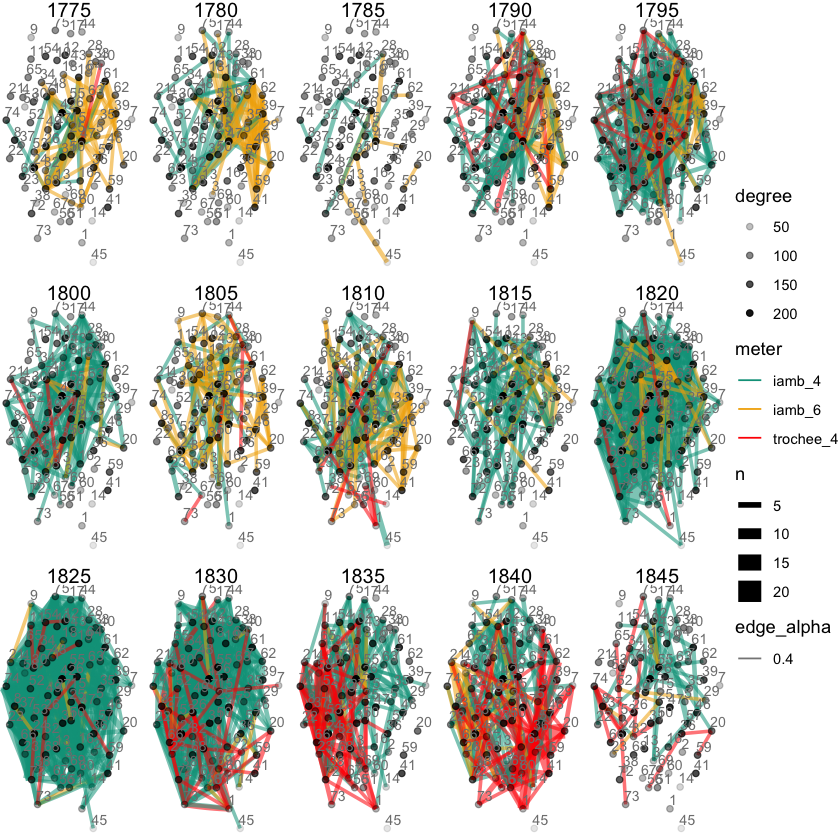

In [29]:
all_nkrja <- network(net, c("iamb_6", "iamb_4", "trochee_4"), 
                     "N", 
                     c(wes_palette("Darjeeling1")[2], wes_palette("Darjeeling1")[3], wes_palette("Darjeeling1")[1]))
all_nkrja

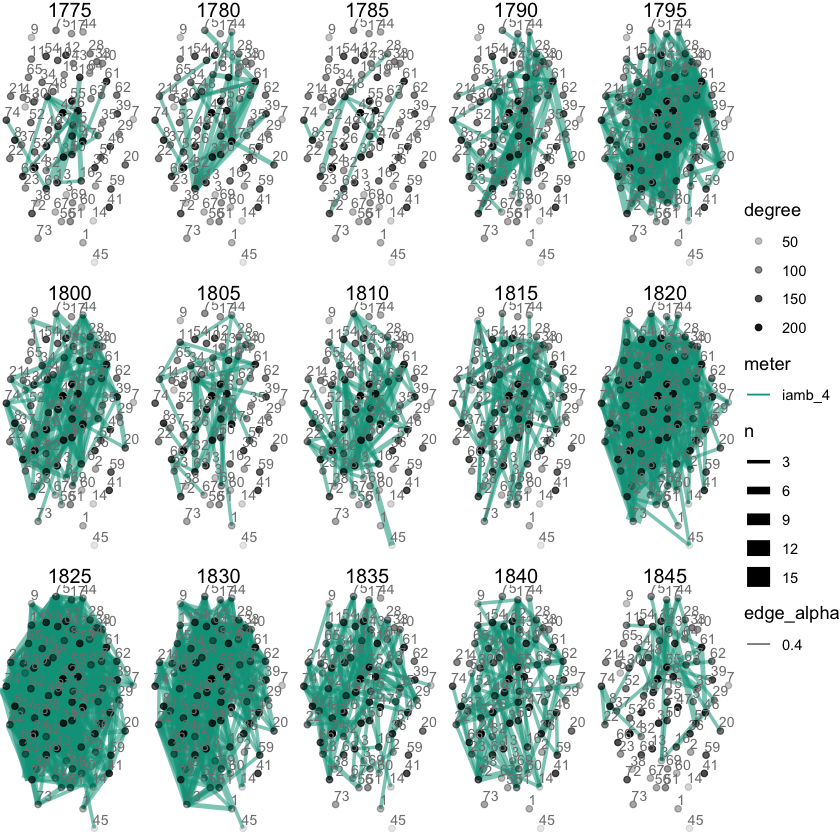

In [37]:
iamb_4 <- network(net, c("iamb_4"), "N",  wes_palette("Darjeeling1")[2]) 
iamb_4 

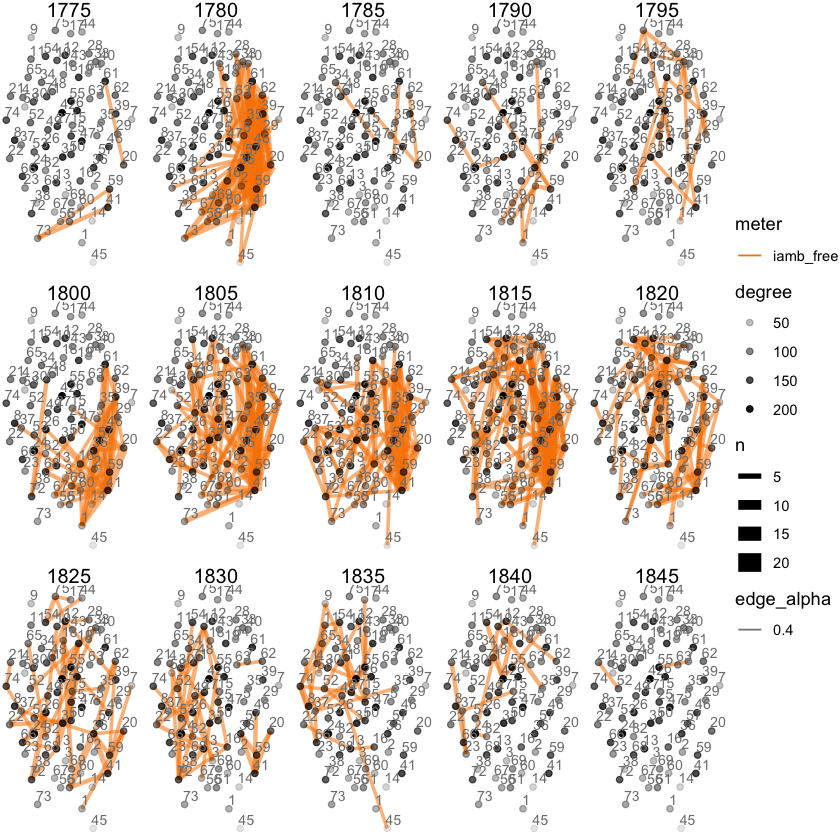

In [38]:
iamb_free <- network(net, c("iamb_free"), "N", wes_palette("Darjeeling1")[4])
iamb_free

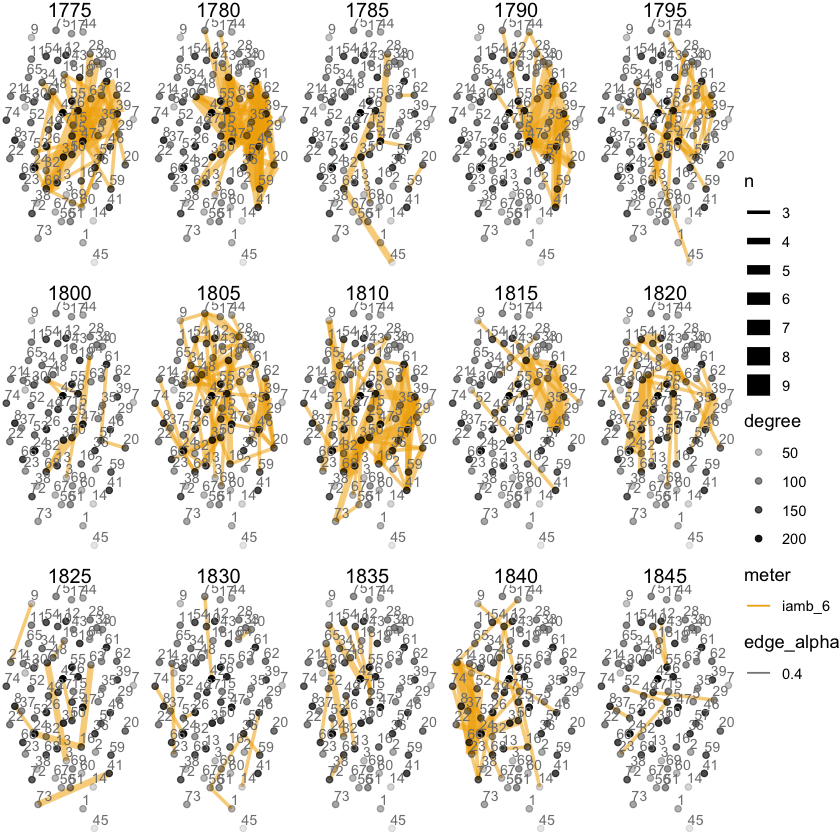

In [39]:
iamb_6 <- network(net, c("iamb_6"), "N", wes_palette("Darjeeling1")[3])
iamb_6

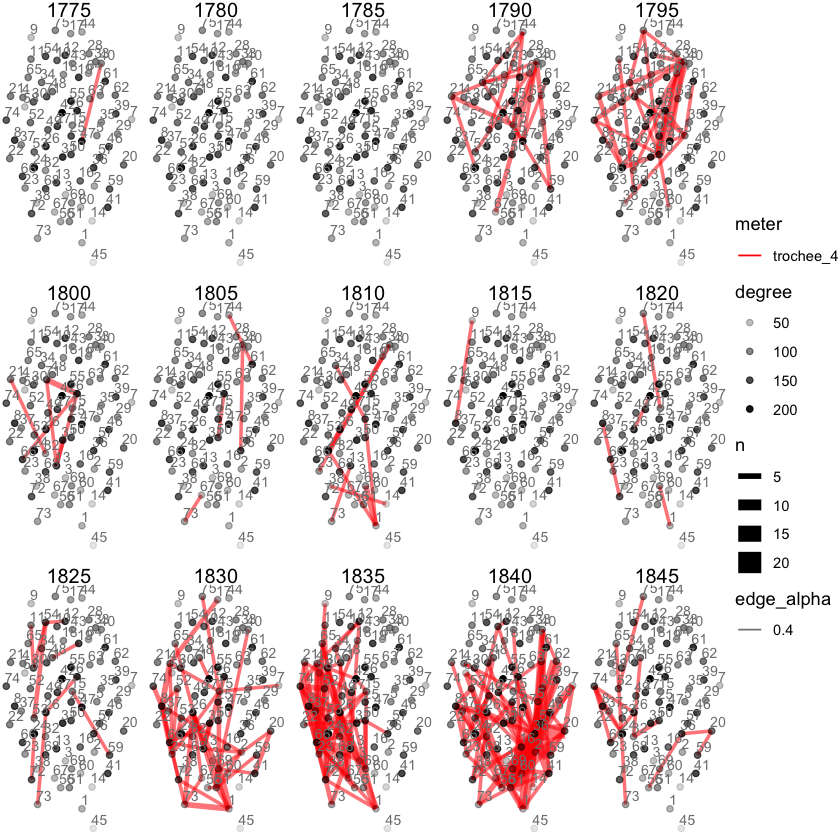

In [40]:
trochee_4 <- network(net, c("trochee_4"), "N", wes_palette("Darjeeling1")[1])
trochee_4

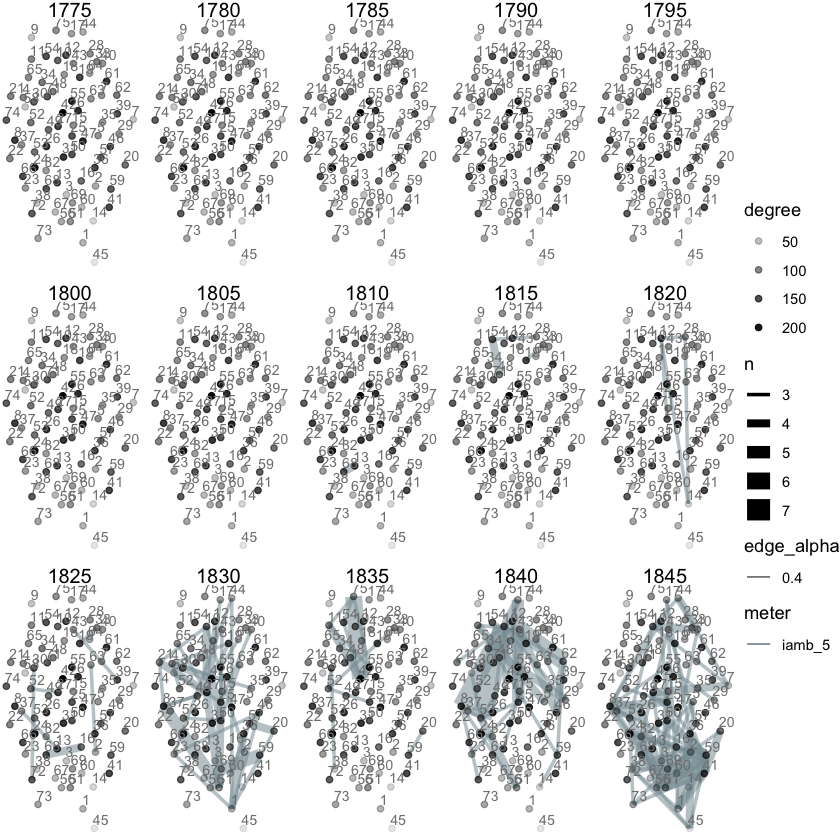

In [44]:
iamb_5 <- network(net, "iamb_5", "N", wes_palette("Royal1")[1])
iamb_5

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <d1>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <80>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <d0>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <b5>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <d0>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zas

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <bb>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <d1>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <8f>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <d1>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <80>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zas

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <d1>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <8f>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <d1>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <80>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <d0>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zas

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <83>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <d0>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <bb>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <d1>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <8f>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zas

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <d0>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <b0>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <d1>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <8f>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <d1>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zas

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <b3>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <d1>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <83>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <d0>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <bb>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zas

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <d0>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <bd>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <d0>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <b0>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <d1>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zas

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <b5>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <d0>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <b3>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <d1>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <83>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zas

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <d1>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <80>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <d0>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <bd>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <d0>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zas

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <80>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <d0>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <b5>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <d0>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <b3>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zas

Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <d1>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <8f>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <d1>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <80>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <d0>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsT

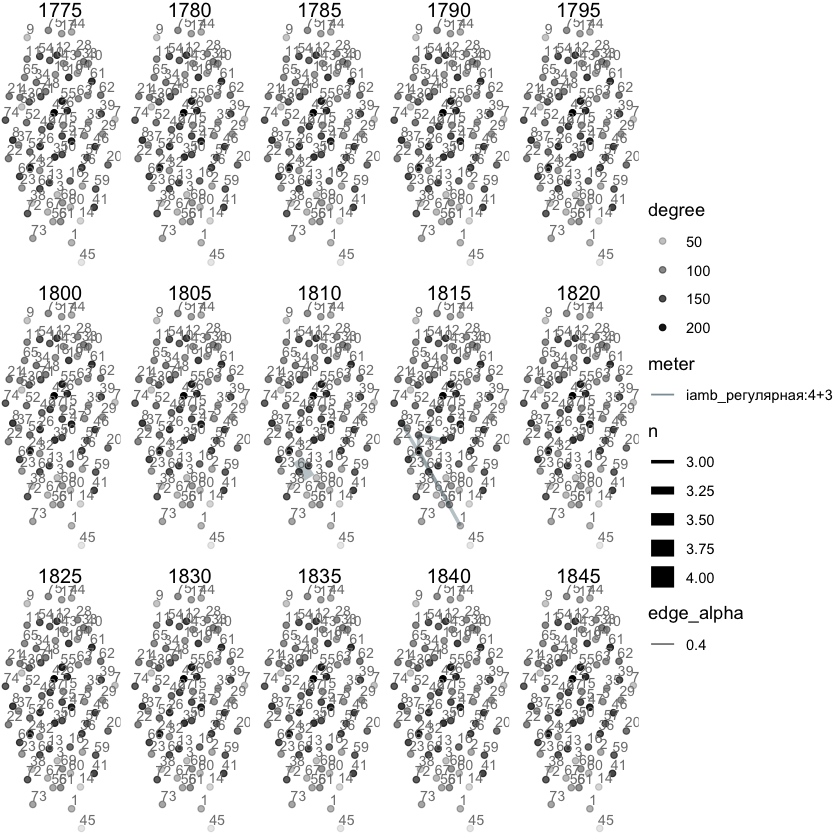

In [43]:
iamb_43 <- network(net, 
                  "iamb_регулярная:4+3", "N", 
                   wes_palette("Royal1")[1])
iamb_43

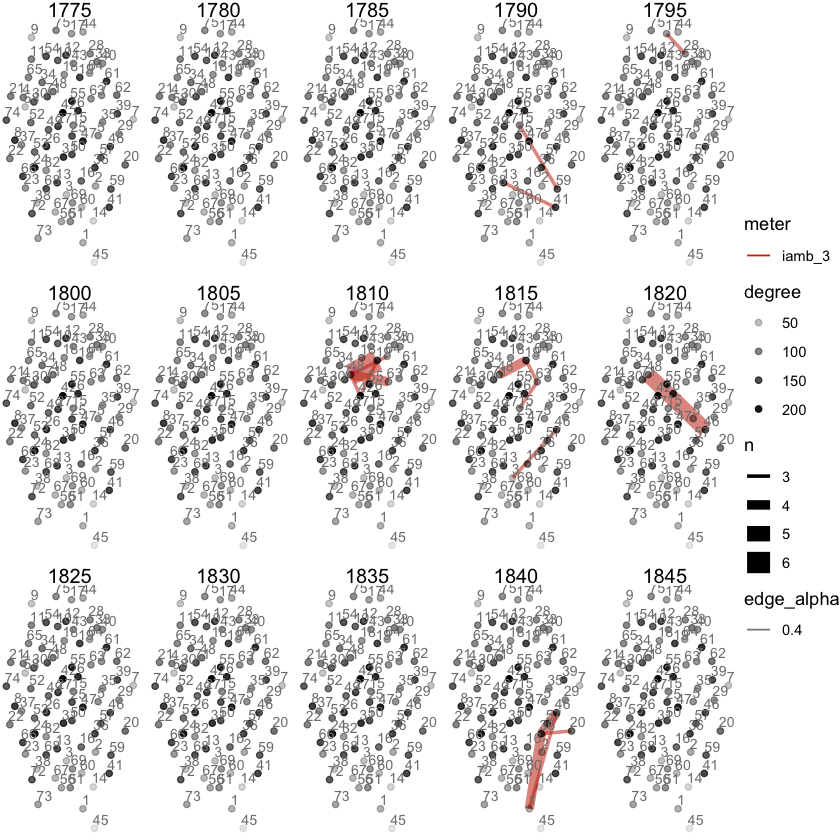

In [47]:
iamb_3 <- network(net, 
                  "iamb_3", "N", 
                   wes_palette("Royal1")[2])
iamb_3

List and save plots

In [99]:
plotlist <- list()

plotlist$all <- all_nkrja
plotlist$iamb_4 <- iamb_4
plotlist$iamb_6 <- iamb_6
plotlist$trochee_4 <- trochee_4

In [100]:
lapply(names(plotlist), function(x)
    ggsave(filename = paste0("../plots/03_network_", x, ".png"), 
           plot = plotlist[[x]],
           height = 8, width = 10, bg = "white"))

[[1]]
[1] "../plots/03_network_all.png"

[[2]]
[1] "../plots/03_network_iamb_4.png"

[[3]]
[1] "../plots/03_network_iamb_6.png"

[[4]]
[1] "../plots/03_network_trochee_4.png"

### Analysis

In [17]:
head(nodelist)

source                                           idn betw     degree
1 57_другой хотеть иной становиться говорить       57  34.81001 151   
2 51_сидеть окно дверь дом стоять                  51  14.59164  90   
3 59_сказать становиться хорошо говорить приходить 59  25.93947 134   
4 42_душа мечта поэт живой восторг                 42  54.97214 219   
5 72_гора лес скала дикий стоять                   72  22.85270 137   
6 62_знать хотеть ничто сказать бояться            62  14.01633 110

In [18]:
head(edgelist)

source                                    
1 41_лев волк зверь собака большой          
2 36_знать говорить точно два очень         
3 57_другой хотеть иной становиться говорить
4 20_богатый жить дом служить бедный        
5 41_лев волк зверь собака большой          
6 19_муза певец слава дар поэт              
  target                                           n  meter     slice corpus
1 57_другой хотеть иной становиться говорить       23 iamb_free 1780  N     
2 51_сидеть окно дверь дом стоять                  20 trochee_4 1840  N     
3 59_сказать становиться хорошо говорить приходить 19 iamb_free 1780  N     
4 57_другой хотеть иной становиться говорить       16 iamb_free 1780  N     
5 59_сказать становиться хорошо говорить приходить 16 iamb_free 1810  N     
6 42_душа мечта поэт живой восторг                 16 iamb_4    1825  N     
  width
1 2.3  
2 2.0  
3 1.9  
4 1.6  
5 1.6  
6 1.6

#### Number of connections for each meter in different slices

In [103]:
print("Number of connections by each meter")
edgelist %>% 
    filter(meter %in% c("iamb_4", "iamb_free", "iamb_6", "trochee_4") & corpus == "N") %>% 
    group_by(meter, slice) %>% 
    count(sort = F) %>% 
    pivot_wider(names_from = slice, values_from = n)


n_texts <- gamma %>% 
    filter(formula %in% c("iamb_4", "iamb_free", "iamb_6", "trochee_4") & corpus == "N") %>% 
    select(index, year, formula) %>% 
    distinct() %>%   
    mutate(slice = floor(as.numeric(year)/5)*5,
          meter_slice = paste0(slice, "__", formula)) %>% 
    group_by(meter_slice) %>% 
    count() %>% 
    rename(n_texts = n)

print("Ratio: number of connections to the number of texts")
edgelist %>% 
    filter(meter %in% c("iamb_4", "iamb_free", "iamb_6", "trochee_4") & corpus == "N") %>% 
    mutate(meter_slice = paste0(slice, "__", meter)) %>% 
    group_by(meter_slice) %>% 
    count(sort = F) %>% 
    rename(n_connections = n) %>% 
    left_join(n_texts, by = "meter_slice") %>% 

    # in this ratio we expect that each text would have at least one connection
    mutate(connection_texts_ratio = round(n_connections/n_texts, 3)) %>% 
    separate(meter_slice, into = c("slice", "meter"), sep = "__") %>% 
    select(slice, meter, connection_texts_ratio) %>%
    pivot_wider(names_from = slice, values_from = connection_texts_ratio)

[1] "Number of connections by each meter"


meter     1775 1780 1785 1790 1795 1800 1805 1810 1815 1820 1825 1830 1835
1 iamb_4    19   27    9   71   185  115  39   72    81  343  610  357  137 
2 iamb_6    44   53    9   30    24    8  56   56    15   27    8    9    9 
3 iamb_free  4   89    4   15    17   50  94   91   117   70   47   31   33 
4 trochee_4  1   NA   NA   15    24    6   4    9     1    4    9   44   68 
  1840 1845
1 99   40  
2 28    6  
3 14    2  
4 84   13

[1] "Ratio: number of connections to the number of texts"


meter     1775  1780  1785  1790  1795  1800  1805  1810  1815  1820  1825 
1 iamb_4    0.284 0.355 0.138 0.430 0.656 0.556 0.253 0.407 0.355 0.706 0.832
2 iamb_6    0.427 0.558 0.170 0.400 0.238 0.114 0.392 0.368 0.139 0.223 0.067
3 iamb_free 0.125 0.489 0.100 0.183 0.163 0.365 0.445 0.386 0.358 0.383 0.245
4 trochee_4 0.045    NA    NA 0.176 0.203 0.079 0.063 0.108 0.018 0.056 0.076
  1830  1835  1840  1845 
1 0.723 0.504 0.409 0.222
2 0.098 0.129 0.237 0.091
3 0.223 0.289 0.177 0.037
4 0.267 0.372 0.285 0.127

### Network density
Calculate network density taking separately each time slice and each meter. The density of a graph is the ratio of the number of edges and the number of possible edges.

In [100]:
density_vector <- function(formula) {
    densities <- vector()
    e1 <- NULL
    for (i in 1:length(unique(edgelist$slice))) {
        e1 <- edgelist %>% 
            filter(meter == formula & slice == unique(edgelist$slice)[i] & corpus == "N")

            net_test <- graph_from_data_frame(d = e1, vertices = nodelist, directed = F)

            densities[i] <- edge_density(net_test, loops = F)
    }
    densities
}

In [92]:
length(unique(edgelist$slice))

[1] 15

In [105]:
density_table <- tibble(meter = c(rep("iamb_4", 15), rep("iamb_6", 15), 
                 rep("iamb_free", 15), rep("trochee_4", 15)),
      slice = rep(unique(edgelist$slice), 4),
      density = round(c(density_vector("iamb_4"),
                       density_vector("iamb_6"),
                       density_vector("iamb_free"), 
                       density_vector("trochee_4")), 3)) %>% 
    arrange(desc(-slice)) 

density_table %>% 
    # pivot for easier reading
    pivot_wider(names_from = slice, values_from = density)

meter     1775  1780  1785  1790  1795  1800  1805  1810  1815  1820  1825 
1 iamb_4    0.007 0.010 0.003 0.026 0.067 0.041 0.014 0.026 0.029 0.124 0.220
2 iamb_6    0.016 0.019 0.003 0.011 0.009 0.003 0.020 0.020 0.005 0.010 0.003
3 iamb_free 0.001 0.032 0.001 0.005 0.006 0.018 0.034 0.033 0.042 0.025 0.017
4 trochee_4 0.000 0.000 0.000 0.005 0.009 0.002 0.001 0.003 0.000 0.001 0.003
  1830  1835  1840  1845 
1 0.129 0.049 0.036 0.014
2 0.003 0.003 0.010 0.002
3 0.011 0.012 0.005 0.001
4 0.016 0.025 0.030 0.005

In [106]:
summary(density_table$density)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.00300 0.01000 0.02125 0.02525 0.22000 

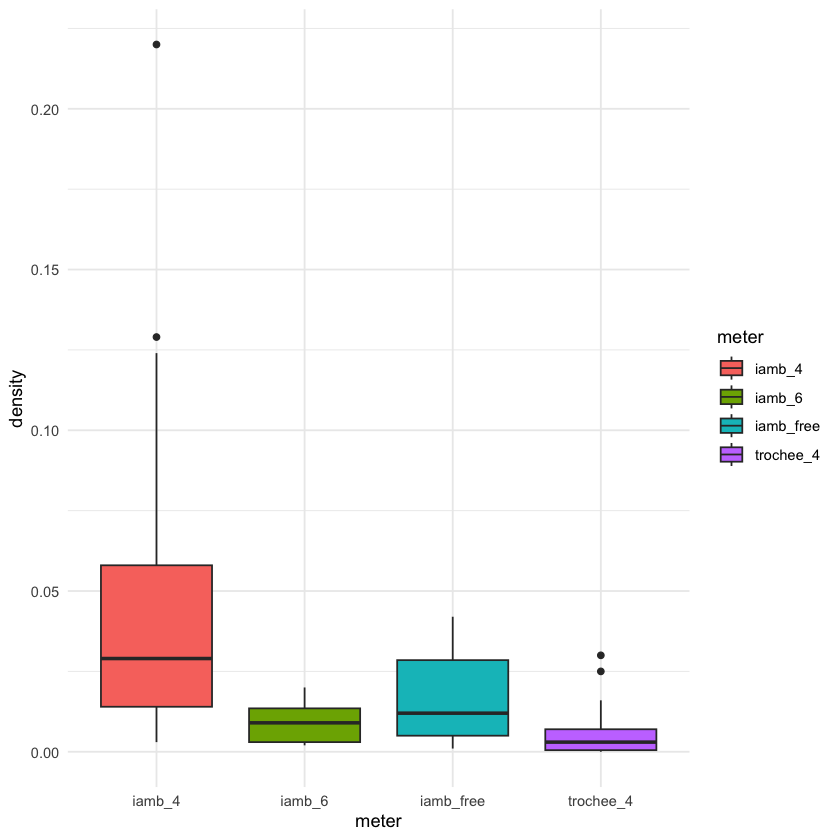

In [109]:
density_table %>% 
    ggplot(aes(x = meter, y = density, fill = meter)) + geom_boxplot()